# Object Recognition with PCA and Synthetic Data

In the DINOv2 paper, the authors use PCA as a form of foreground masking for objects in images. In practice I found this to be unreliable for complex images and scenes with multiple different object classes.

To improve segmentation and extend foreground separation to object class detection, this notebook employs the use of synthetic data and PCA filtering to extract sample tokens. These curated tokens can then be used in PCA with new complex images for dense object detection.

Although similar in approach to examples in the paper, this methodology appears to increase output quality.

## Install Required Dependencies

We only need to install a couple deps, like torch and a couple huggingface libraries. They're listed in the `requirements.txt` file.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Image Plotting

Since we're working with images, let's define a small helper function for displaying them.

In [2]:
import matplotlib.pyplot as plt

def plot_images(images, labels=None):
    figsize = 20 if len(images) > 1 else 10
    plt.figure(figsize=(figsize, figsize))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis("off")
        if labels:
            plt.title(labels[i])
    plt.show()

## Input Image

For our input image, I want to have a couple objects and have our goal to be identifiying the dog. We can use SDXL to generate a sample input image of a dog playing with a soccer ball.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

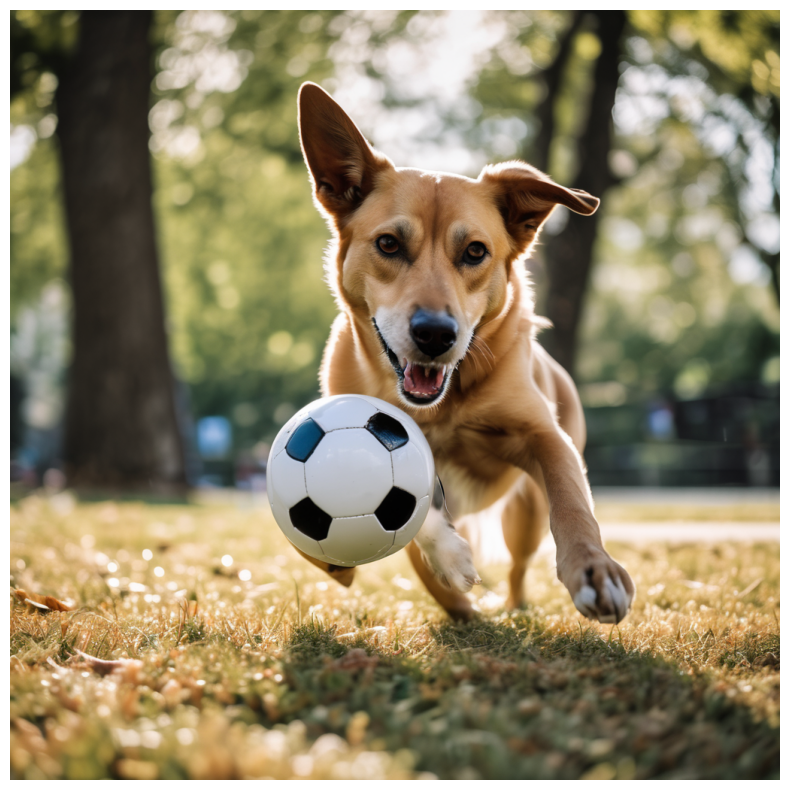

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers.utils import is_xformers_available
import torch

img_size=1024
sdxl_model_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionXLPipeline.from_pretrained(sdxl_model_id, torch_dtype=torch.float16, variant="fp16").to("cuda")

pipe.enable_vae_slicing()
if is_xformers_available():
    pipe.enable_xformers_memory_efficient_attention()

input_image = pipe(
    prompt="A photo of a dog playing with a soccer ball in a park",
    guidance_scale=8.0,
    num_inference_steps=100,
).images[0]

plot_images([input_image])

## Synthetic Example Data

Since we want to look for dogs in our inputs, we need some example data to get "dog vectors" from. Instead of collecting these ourselves, we can simply tell SDXL what object we want to look for. Neat!

  0%|          | 0/50 [00:00<?, ?it/s]

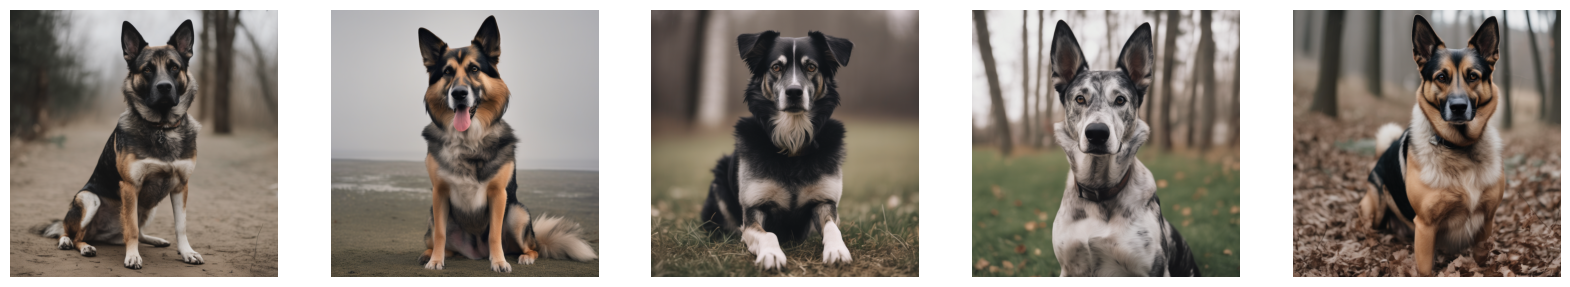

In [4]:
num_guides = 5

guide_images = pipe(
    prompt=["A high quality photo of a fullbody dog"] * num_guides,
    guidance_scale=8.0,
    num_inference_steps=50,
).images

plot_images(guide_images)

In [5]:
del pipe
torch.cuda.empty_cache()

## Extracting DINOv2 Features

Now that we have our example images and our input, we can extract the patch features with DINOv2. As described in the paper, these are highly general purpose features which can be used in many downstream tasks. For our purposes, we will be using the features in PCA.

In [6]:
from transformers import AutoImageProcessor, Dinov2Model

dino_model_id = "facebook/dinov2-base"

image_processor = AutoImageProcessor.from_pretrained(dino_model_id, do_center_crop=False, do_resize=False)
model = Dinov2Model.from_pretrained(dino_model_id, device_map="cuda:0")

inputs = image_processor(images=[input_image] + guide_images, return_tensors="pt").to("cuda:0")

with torch.inference_mode():
    outputs = model(**inputs)

patch_features = outputs.last_hidden_state[:, 1:, :] # remove the CLS token

DINOv2 outputs a set of flat features, so we can make a helper function to unflatten them later.

In [7]:
def unflatten_features(features, batch_size=1, patch_size=14):
    return features.reshape(batch_size, img_size // patch_size, img_size // patch_size, -1)

In [8]:
del image_processor, model
torch.cuda.empty_cache()

## PCA Thresholding

Like in the DINOv2 paper, we can perform PCA to extract the foreground object from an image. We can do this in Pytorch with SVD if or data is centered on the mean. We can use 3 components for visualization purposes.

After performing PCA we can threshold and vectors with a negative first components.

In [9]:
def thresholded_pca(x, n_components=3):
    # center the data
    x_mean = torch.mean(x, dim=0)
    x = x - x_mean

    # perform SVD and get principal components
    _, _, v = torch.svd(x)
    components = torch.mm(x, v[:, :n_components])

    # mask on positive primary component
    mask = components[:, 0] > 0

    # normalize
    min_val = torch.min(components)
    max_val = torch.max(components)
    components = (components - min_val) / (max_val - min_val)

    # apply threshold mask
    components = components * mask[:, None].float()

    return components


## Getting Dog Tokens

Now that we have our guidance data made of synthetic examples and our PCA function, we can perform PCA on all vectors in the guidance data. As described in the paper, this operation acts as a foreground object detector.

In practice this step can be hit or miss. Detecting the foreground object reliably requires a sort of simplicity to the images and/or lots of samples. By using synthetic data, we can curate our prompts to frame our guidance objects in ways suitable for this process.

After we have our thresholded PCA values, we can use it as a mask to filter out non-dog tokens in our patch features.

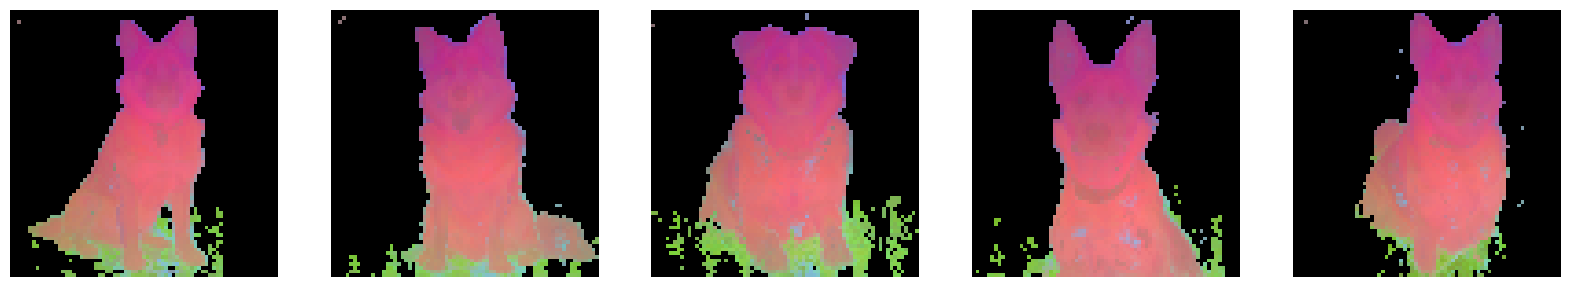

In [10]:
# extract guide patch features and flatten
guide_patch_features = patch_features[1:]
flat_guide_patch_features = guide_patch_features.reshape(-1, guide_patch_features.shape[-1]).cpu()

# perform PCA and filter for our dog tokens
pca_patch_features = thresholded_pca(flat_guide_patch_features)
guide_patch_features_filtered = flat_guide_patch_features[pca_patch_features[:, 0] > 0]

# unflatten for display
pca_patch_features = unflatten_features(pca_patch_features, batch_size=num_guides)

plot_images(pca_patch_features)

## Where's Lassie?

Now that we have a filtered list of dog tokens from the previous step, we can now use these in a second PCA with our input image.
Highly saturating our vector space with dog tokens helps get a more accurate mask on the input and in more complex scenes.

Next to the input image we can see the extract patches when using our filtered example data.
We can also see what patches we get if we use unfiltered example data, as well as no example data at all.

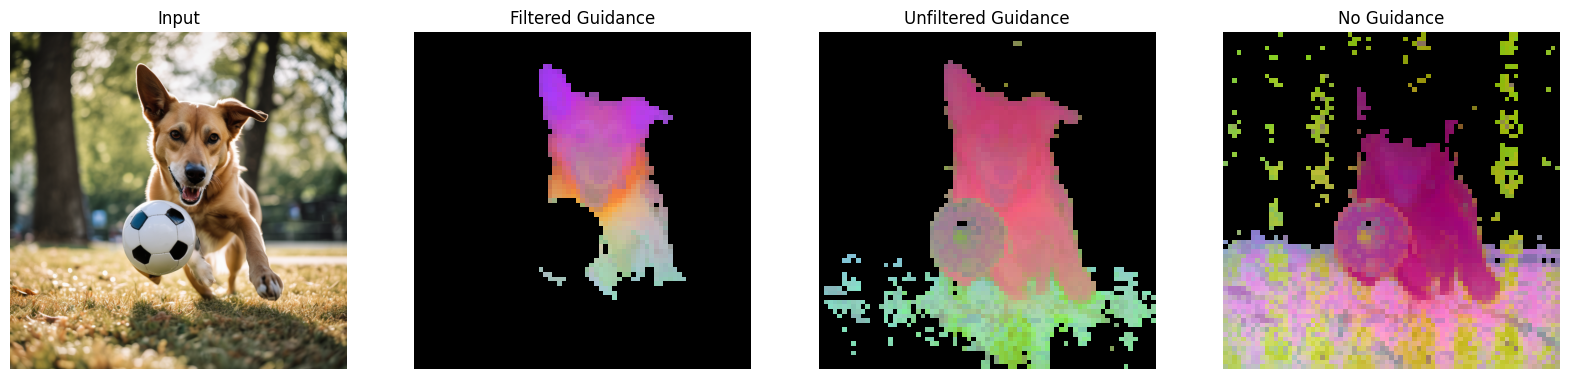

In [11]:
# perform combined PCA on input patches and filtered guide patches
input_patch_features = patch_features[0].cpu()

# get patches with filtered example data
pca_patch_features = thresholded_pca(
        torch.cat([input_patch_features, guide_patch_features_filtered], axis=0)
    )[:input_patch_features.shape[0]]

# get patches with unfiltered example data
pca_unfiltered_guidance = thresholded_pca(
        torch.cat([input_patch_features, flat_guide_patch_features], axis=0)
    )[:input_patch_features.shape[0]]

# get patches without example data
pca_no_guidance = thresholded_pca(input_patch_features)

feature_maps = [unflatten_features(f).squeeze(0) for f in [pca_patch_features, pca_unfiltered_guidance, pca_no_guidance]]

plot_images([input_image] + feature_maps, labels=["Input", "Filtered Guidance", "Unfiltered Guidance", "No Guidance"])


## What About Tigers?

A dog playing soccer is cool, but a tiger player soccer is way cooler.
Using the filtered PCA components from the previous step, we can create a mask for image inpainting.

To improve the quality of the mask, we can first dilate it with a convolution to get better coverage and remove any small holes.
Then we use bilinear upsample and rounding to get a smoother and higher resolution mask.

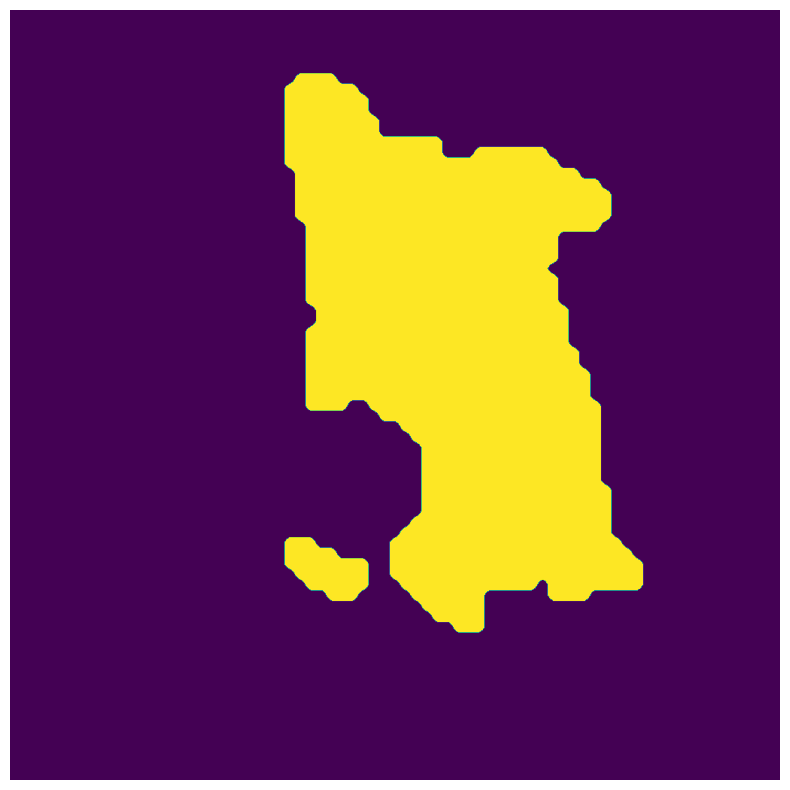

In [12]:
import torch.nn.functional as F

# create mask from thresholded PCA components
mask = unflatten_features(pca_patch_features[..., 0]) > 0
mask = mask.permute(0, 3, 1, 2).float()

# dilate the mask to cover more area
mask = F.conv2d(mask, torch.ones(1, 1, 3, 3), padding=1) > 0

# upsample and round to get a smoother and higher resolution mask
mask = F.interpolate(mask.float(), size=(img_size, img_size), mode="bilinear").round()
mask = mask[0, 0]

plot_images([mask])

## Object Replacement

All that's left to do us pass the input image and the mask to an SDXL inpainting pipeline. We can prompt it for whatever we'd like, such as a baby tiger playing soccer.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

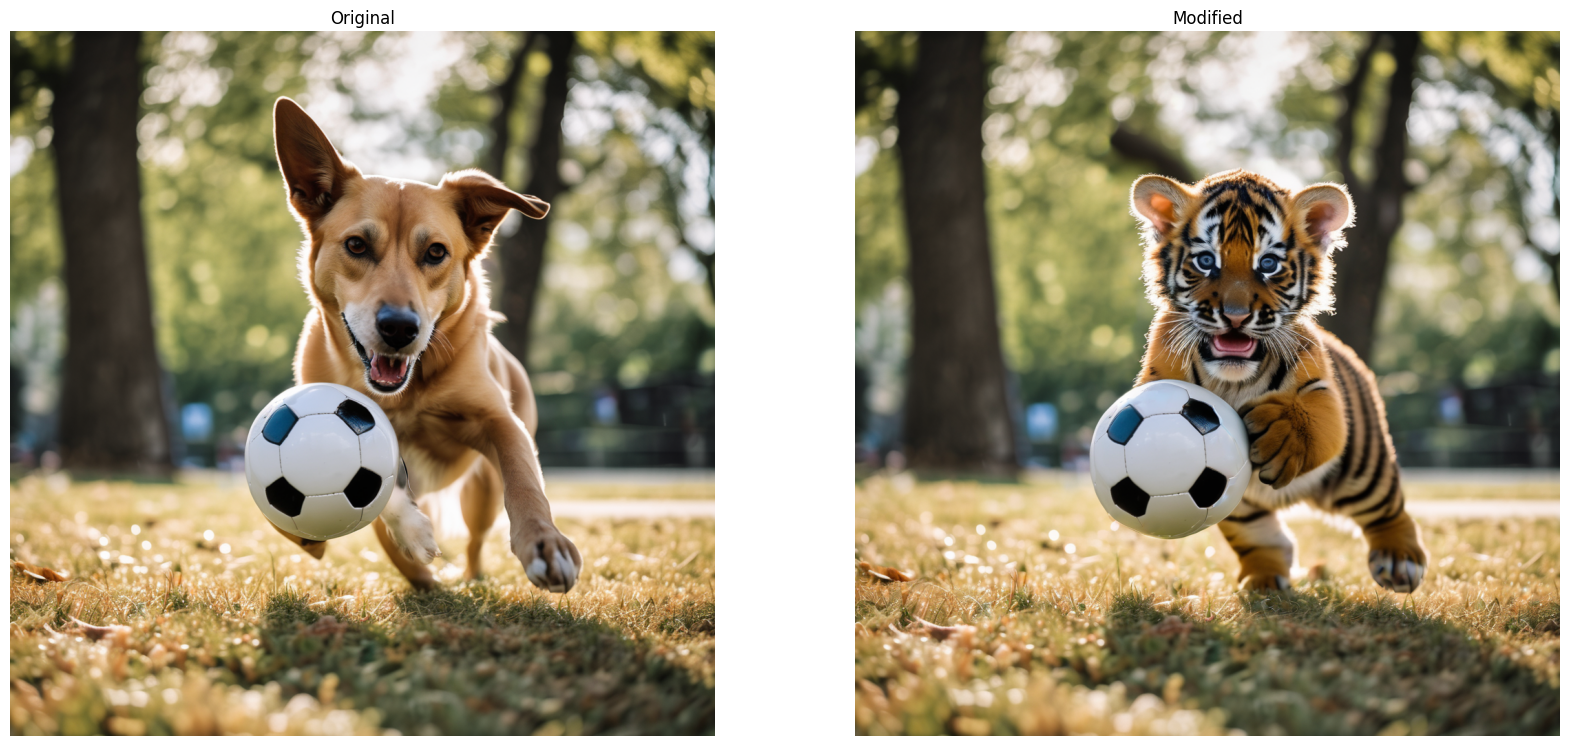

In [13]:
from diffusers import StableDiffusionXLInpaintPipeline

pipe = StableDiffusionXLInpaintPipeline.from_pretrained(sdxl_model_id, torch_dtype=torch.float16, variant="fp16").to("cuda")

pipe.enable_vae_slicing()
if is_xformers_available():
    pipe.enable_xformers_memory_efficient_attention()

inpaint_image = pipe(
    prompt="A photo of a baby tiger playing with a soccer ball in a park",
    image=input_image,
    mask_image=mask,
    guidance_scale=8.0,
    num_inference_steps=50,
    strength=0.75
).images[0]

plot_images([input_image, inpaint_image], labels=["Original", "Modified"])